# Set-Up

In [11]:
# !pip install tsfresh
# !wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/x_ts_L60_Z12_A500_DX50_bias5_N10000.dat
# !wget https://raw.githubusercontent.com/DanHarJor/CompLabB-UNIPD-TeamDream/main/Daniel/04_XGBoost/DATA/y_ts_L60_Z12_A500_DX50_bias5_N10000.dat

#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y3qcM4OSrzfQhj-iHyJF86TUQJNUXOE9' -O x_features_pick


In [12]:
import os
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as mark
from tsfresh import extract_features
from xgboost import XGBClassifier, plot_tree

#create a random number generator 'rng' for data shuffles
rng = np.random.default_rng()

plt.rcParams['font.size'] = 14

#Load, scale and split Data ################################################################
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='x_'+str0
fnamey='y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

#rescale
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#rescale crude
x = x/400

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)

x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)
##########################################################################

def Show_data(x,L,nSamples = 2,title="data"):
    plt.figure(figsize = (nSamples*3,10))
    for i in range(nSamples):
        plt.plot(np.arange((i+1)*L,(i+1)*L+L),x[i])
        #plt.plot(np.arange(L,2*L),x[1])
        #plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(title)
    plt.xlabel("time")
    plt.show()

def Show_history(fit, EPOCHS):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

##method 1
import tensorflow.random as tf_r
def compile_CNN(regLevel = 0.2):
    np.random.seed(12345)    
    tf_r.set_seed(12345)
    ## from keras import regularizers, initializers
    reg = tf.keras.regularizers.l1(regLevel) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=None)
    model = Sequential()
    # -----2-- Convelutional layers
    model.add(Conv1D(filters=5, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

#used to remember best weights
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = os.getcwd(),
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose = 0)
CNN = compile_CNN()


data:  10000


# CNN at various data sizes

In [13]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
batch_sizes = [10,20,30,50,50,50,100,100,100,250,250,250,250,250,250,250,250]
CNN_mean_acc = []
CNN_std_acc = []
CNN_acc = []

EPOCHS = 100 #needs tuned for comparison with XGBoost
for i in range(len(Ndat)):
    CNN_acc_temp = []
    N = Ndat[i]
    if i < 9:
        BATCH_SIZE =  batch_sizes[i] #not sure
    else: BATCH_SIZE = 250
    
    for j in range(10):
      #shuffle data
      permutation = rng.permutation(x_train.shape[0])
      # resize data
      s_x_train = (x_train[permutation])[0:N,:]
      s_y_train = (y_train[permutation])[0:N]
      #s_x_val = x_val[0:int(0.2*N),:]
      #s_y_val = y_val[0:int(0.2*N)]
    
      #train and test CNN
      CNN = compile_CNN()
      fit = CNN.fit(s_x_train,s_y_train,batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(x_val, y_val),
                      verbose=0, shuffle=True, callbacks=[model_checkpoint_callback])
      maxAcc = np.max(fit.history['val_accuracy'])
      CNN_acc_temp.append(maxAcc)
    print(CNN_acc_temp)
    CNN_acc.append(CNN_acc_temp)
    CNN_mean_acc.append(np.mean(CNN_acc_temp))
    CNN_std_acc.append(np.std(CNN_acc_temp))


INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written to: /content/assets
INFO:tensorflow:Assets written 

No handles with labels found to put in legend.


18
18
[0.023716239711725005, 0.024514531773833646, 0.050575291089744706, 0.039453164893525496, 0.06331239549521014, 0.05653458285138375, 0.06423939425642447, 0.10877271366322738, 0.13383430624504156, 0.10427804466177573, 0.11995745195025076, 0.11355823708408758, 0.14189679876391822, 0.03497645802584678, 0.011792050776463843, 0.15393009173200622, 0.1977630184391818, 0.21640774591500445]


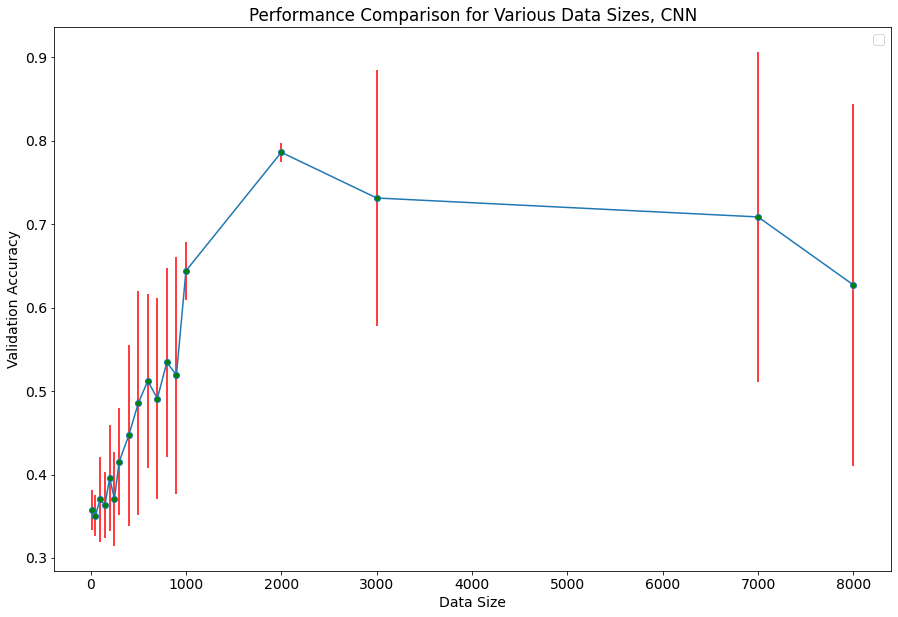

In [15]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
print(len(Ndat))
print(len(CNN_mean_acc))
figDataSize = plt.figure(figsize = (15,10))
#plt.plot(Ndat,CNN_mean_acc, 'r.-', label = 'CNN')
plt.errorbar(Ndat,CNN_mean_acc, yerr = CNN_std_acc,ecolor = 'r', marker = 'o',mfc = 'g')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
#plt.xticks(Ndat,Ndat)
plt.title('Performance Comparison for Various Data Sizes, CNN')
plt.legend()

print(CNN_std_acc)

# XGBoost with tsfresh

In [4]:
#turn data into a dataframe that is compatable with tsfresh
def get_df(x):
    '''Build input dataframe for given data series
    Input:
    var = array of time series, (#samples,time,1)
    Return:
    df = dataframe ready for features extraction
    '''
    
    #N = #samples, t = timesteps
    N, t = x.shape[0], x.shape[1]
    #build id columns
    id_col = np.repeat(np.arange(N),t)
    #build time columns
    time_col = np.tile(np.arange(t),N)
    #build var columns
    x_col = x.flatten()
      
    #build dict for df
    x_dict = {'id':id_col,'time':time_col,'value':x_col}
        
    #return dataframe
    return pd.DataFrame(x_dict)

df = get_df(x)

#extract features
# x_features = extract_features(
#                             df, #our dataframe
#                             column_id='id', #sample id, from 0 to N
#                             column_sort='time', #timestep, from 0 to t
#                             column_kind=None, #we have only one feature
#                             column_value='value', #value of input 
#                             n_jobs=1) #number of cores



In [1]:

import pickle
##save to pickle file
#with open('x_features_pick', 'wb') as file:
#    pickle.dump(x_features, file)


#load from pickle file
with open('x_features_pick', 'rb') as file:
     x_features = pickle.load(file)


In [5]:
#remove columns with NaN or inf
x_features.replace([np.inf, -np.inf], np.nan)
x_features = x_features.dropna(axis='columns')

#split data into training and validation
perc_train=0.8
N_train = int(perc_train*N)
x_train = x_features[0:N_train]
y_train_xgb = categ[0:N_train]
x_val = x_features[N_train:]
y_val_xgb = categ[N_train:]
N_val = len(x_val)
print('N = ',N,'   N_train=',N_train,'  N_val=',N_val,'  n_class=',n_class)

#rescale: in each feature, remove average and divide by std
average = np.mean(x_train,axis=0)
x_train -= average
x_val -= average

std = np.std(x_train,axis=0)
x_train /= std
x_val /= std

def XGB_compile():
    # reproducibility
    np.random.seed(12345)

    #define parameters for xgboost
    params = {'max_depth':6,'min_child_weight':1,\
              'learning_rate':0.3,'use_label_encoder':False}

    #build model with given params
    model = XGBClassifier(**params)
    return model


N =  10000    N_train= 8000   N_val= 2000   n_class= 3


In [7]:
Ndat = [20,50,100,150,200,250,300,400,500,600,700,800,900,1000,2000,3000,7000,8000]
fracs = np.array(Ndat)/8000
XGB_mean_acc = []
XGB_std_acc = []
XGB_acc = []

for i in range(len(Ndat)):
    XGB_acc_temp = []
    
    for j in range(5):
      #shuffle data and resize
      shuffle = x_train.sample(frac = fracs[i])
      index = shuffle.index.tolist()
      # resize data
      s_x_train = shuffle#.reset_index()
      s_y_train = (y_train_xgb[index])[0:len(index)]
      #s_x_val = x_val[0:int(0.2*N),:]
      #s_y_val = y_val[0:int(0.2*N)]
      XGB = XGB_compile()
      fit = XGB.fit(s_x_train.values,s_y_train)
      y_pred = XGB.predict(x_val.values)
      acc = np.sum([y_pred == y_val_xgb])/len(y_val_xgb)
      XGB_acc_temp.append(acc)
    XGB_acc.append(XGB_acc_temp)
    XGB_mean_acc.append(np.mean(XGB_acc_temp))
    XGB_std_acc.append(np.std(XGB_acc_temp))


No handles with labels found to put in legend.


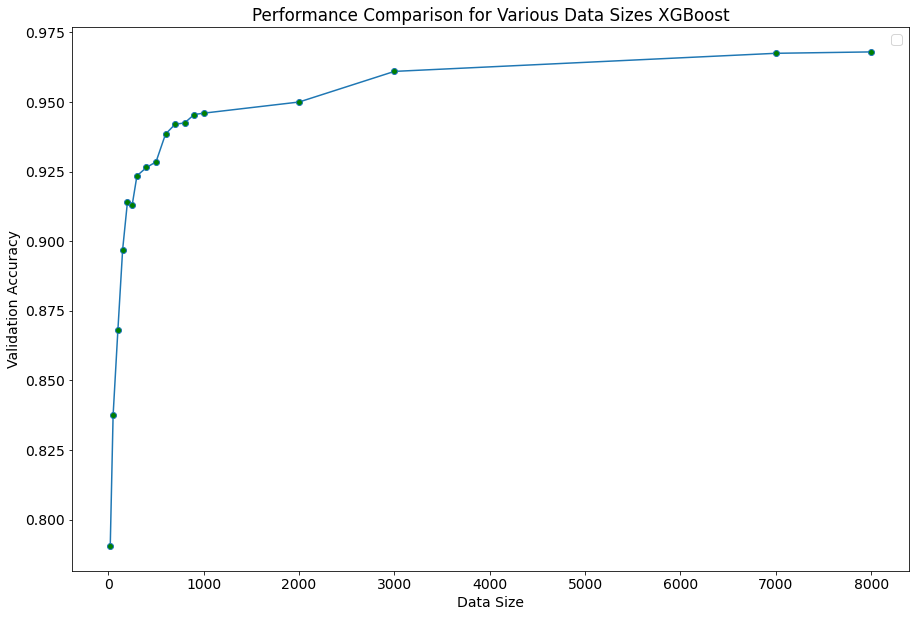

In [16]:
figDataSize = plt.figure(figsize = (15,10))
plt.errorbar(Ndat,XGB_mean_acc, yerr = XGB_std_acc,ecolor = 'r', marker = 'o',mfc = 'g')
plt.title('Performance Comparison for Various Data Sizes XGBoost')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
plt.legend()

In [9]:
print(XGB_std_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 1.1102230246251565e-16, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Comparing XGBoost with CNN

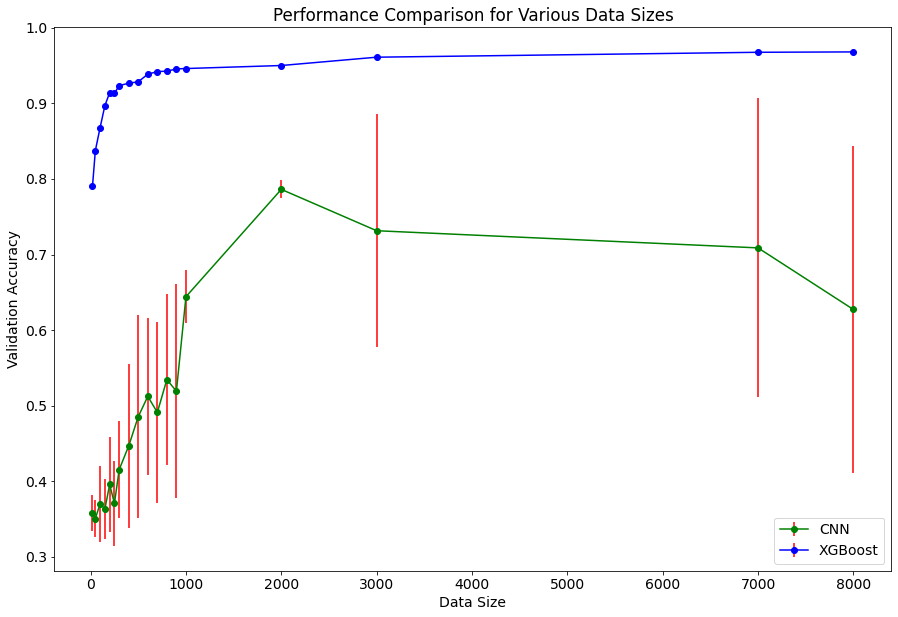

In [18]:
figDataSize = plt.figure(figsize = (15,10))
plt.errorbar(Ndat,CNN_mean_acc, yerr = CNN_std_acc,ecolor = 'r', marker = 'o',mfc = 'g', color = 'g', label = 'CNN')
plt.errorbar(Ndat,XGB_mean_acc, yerr = XGB_std_acc,ecolor = 'r', marker = 'o',mfc = 'b', color = 'b',label = 'XGBoost')
plt.xlabel('Data Size')
plt.ylabel('Validation Accuracy')
plt.title('Performance Comparison for Various Data Sizes')
plt.legend()

# Conclusion

XGBoost massivly outperformes the CNN. It is more stable which can be seen by the lack of variance with different runs. It achieves a higher accuracy at all of the data sizes. 

I suspect this is because of the simplicity of the problem. Perhaps the CNN could outperform XGBoost in solving more complex problems with even larger datasets. 